In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics as mtr
# from sklearn.feature_selection import RFECV
from sklearn.metrics import cohen_kappa_score, make_scorer

In [2]:
# Read VT data
data_df = pd.read_pickle("../data/interim/vtdata.pkl")
data_df = data_df.sample(frac=1, random_state=7).reset_index(drop=True)

vt_X = data_df.drop(columns="vt")
vt_y = data_df["vt"]

# ...and drop unwanted features to avoid spatial overfitting
vt_X = vt_X.drop(['x', 'y', 'plot_id'], axis=1)
print(vt_X.columns)
vt_X.head()

Index(['B11_median_comp_Sent2', 'B12_median_comp_Sent2',
       'B1_median_comp_Sent2', 'B2_median_comp_Sent2', 'B3_median_comp_Sent2',
       'B4_median_comp_Sent2', 'B5_median_comp_Sent2', 'B6_median_comp_Sent2',
       'B7_median_comp_Sent2', 'B8A_median_comp_Sent2', 'B8_median_comp_Sent2',
       'B9_median_comp_Sent2', 'EVI_greenest_pixel_Sent2',
       'EVI_median_comp_Sent2', 'GNDVI_greenest_pixel_Sent2',
       'GNDVI_median_comp_Sent2', 'NDMI_greenest_pixel_Sent2',
       'NDMI_median_comp_Sent2', 'NDVI_greenest_pixel_Sent2',
       'NDVI_median_comp_Sent2', 'SAVI_greenest_pixel_Sent2',
       'SAVI_median_comp_Sent2', 'B1_median_comp_Lands7',
       'B2_median_comp_Lands7', 'B3_median_comp_Lands7',
       'B4_median_comp_Lands7', 'B5_median_comp_Lands7',
       'B6_median_comp_Lands7', 'B7_median_comp_Lands7',
       'EVI_greenest_pixel_Lands7', 'EVI_median_comp_Lands7',
       'GNDVI_greenest_pixel_Lands7', 'GNDVI_median_comp_Lands7',
       'NDMI_greenest_pixel_Lands7', 'ND

,B11_median_comp_Sent2,B12_median_comp_Sent2,B1_median_comp_Sent2,B2_median_comp_Sent2,B3_median_comp_Sent2,B4_median_comp_Sent2,B5_median_comp_Sent2,B6_median_comp_Sent2,B7_median_comp_Sent2,B8A_median_comp_Sent2,...,tmax_6,tmax_8,tmax_9,tmin_5,tmin_9,topographic_wetness_index,total_insolation,valley_depth,vertical_distance_to_channel_network,visible_sky
0,0.21700,0.12775,0.04157,0.04070,0.05858,0.05915,0.10155,0.17385,0.19245,0.21790,...,20.5811,18.1146,12.9765,-4.5616,-1.6503,8.1780,1168.90918,121.9962,163.3139,94.1729
1,0.07680,0.03780,0.01560,0.01945,0.02982,0.01820,0.04752,0.12807,0.15217,0.16735,...,22.5382,20.2714,17.2824,0.7850,0.4542,6.8749,1211.49475,64.2473,25.2764,97.7724
2,0.20360,0.09220,0.06630,0.03990,0.06280,0.04020,0.12070,0.31450,0.35760,0.38720,...,17.6708,20.3218,14.5407,-3.4983,-2.3515,17.6024,993.73572,748.6170,0.0000,84.9623
3,0.22508,0.13655,0.02765,0.04070,0.06180,0.06697,0.11375,0.22545,0.25670,0.29110,...,21.9165,20.5618,15.8932,2.0480,4.8671,7.2655,1118.61890,103.4937,46.4838,94.7372
4,0.24625,0.13610,0.03075,0.04715,0.07305,0.07145,0.14155,0.25710,0.28145,0.31650,...,14.7530,16.7801,13.4581,-7.0645,-1.2334,7.3559,1399.06226,229.2504,62.1383,94.1043


In [14]:
vt_X['geo_infiltr_evne'].unique().categories

Index([1, 2, 3, 4, 5], dtype='int64')

In [3]:
# Load CV indices
with open('../data/misc/vtdata_5f_spatial_cv_indices.pkl', 'rb') as file:
    split_indices = pickle.load(file)

split_indices

[(array([    0,     1,     3, ..., 22168, 22169, 22170]),
  array([    2,     7,     9, ..., 22157, 22171, 22172])),
 (array([    0,     1,     2, ..., 22170, 22171, 22172]),
  array([   14,    58,    67, ..., 22158, 22166, 22167])),
 (array([    0,     1,     2, ..., 22168, 22171, 22172]),
  array([   11,    12,    23, ..., 22164, 22169, 22170])),
 (array([    0,     2,     4, ..., 22170, 22171, 22172]),
  array([    1,     3,     6, ..., 22163, 22165, 22168])),
 (array([    1,     2,     3, ..., 22170, 22171, 22172]),
  array([    0,     4,     5, ..., 22146, 22159, 22162]))]

In [4]:
scores = {
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}
scores

{'cohen_kappa': make_scorer(cohen_kappa_score),
 'accuracy': 'accuracy',
 'f1_macro': 'f1_macro'}

In [81]:
# CUSTOM RECURSIVE FEATURE ELIMINATION IMPLEMENTATION USING PERMUTATION IMPORTANCE
min_feats_to_select = 2
verbose = True

rfe_vt_X = vt_X.copy()
rfe_vt_y = vt_y.copy()

dropped_columns = []
included_columns = []
rfe_importances_mean = []
rfe_importances_std = []
rfe_accuracies_mean = []
rfe_accuracies_std = []

iter_idx = len(vt_X.columns)

while iter_idx >= min_feats_to_select:

    if verbose:
        print(f"Starting to calculate CV permutation importance with {iter_idx} features.")

    cur_fold_importances_mean = np.zeros(shape=(iter_idx,), dtype=float)
    cur_fold_importances_std = np.zeros(shape=(iter_idx,), dtype=float)
    cur_fold_accuracies = []

    # Calculate permutation importance for cv
    for fold_idx, (train_indices, test_indices) in enumerate(split_indices):

        estimator = RandomForestClassifier(n_jobs=20, random_state=221)
        
        # Fit estimator
        estimator.fit(
            X=rfe_vt_X.iloc[train_indices],
            y=rfe_vt_y.iloc[train_indices],
        )

        cur_predictions = estimator.predict(rfe_vt_X.iloc[test_indices])
        cur_fold_accuracies.append(
            mtr.accuracy_score(
                y_true=rfe_vt_y.iloc[test_indices],
                y_pred=cur_predictions,
            )
        )

        # Calculate permutation importance on held out data
        cur_perm_importance = permutation_importance(
            estimator=estimator,
            X=rfe_vt_X.iloc[test_indices],
            y=rfe_vt_y.iloc[test_indices],
            scoring='accuracy',
            n_repeats=5,
            random_state=221,
            n_jobs=5,
        )

        cur_fold_importances_mean += cur_perm_importance['importances_mean']
        cur_fold_importances_std += cur_perm_importance['importances_std']

        if verbose:
            print(f"Finished fold {fold_idx+1} of {len(split_indices)} with {iter_idx} features.")

    # Calculate accuracy mean and std
    rfe_accuracies_mean.append(
        float(np.mean(cur_fold_accuracies))
    )
    rfe_accuracies_std.append(
        float(np.std(cur_fold_accuracies))
    )

    # Calculate mean CV importance
    cur_fold_importances_mean /= len(split_indices)
    cur_fold_importances_std /= len(split_indices)
    rfe_importances_mean.append(cur_fold_importances_mean)
    rfe_importances_std.append(cur_fold_importances_std)

    # Determine least informative feature
    worst_feature_idx = np.where(
        cur_fold_importances_mean == cur_fold_importances_mean.min()
    )
    # Get var names at index
    cur_vars_to_drop = list(rfe_vt_X.columns[worst_feature_idx])

    if verbose:
        print(f"Current accuracy: {rfe_accuracies_mean[-1]}")
        print(
            f"Dropping: {cur_vars_to_drop} with importance {cur_fold_importances_mean[int(worst_feature_idx[0])]}"
            + f"(±{cur_fold_importances_std[int(worst_feature_idx[0])]})"
        )
    rfe_vt_X = rfe_vt_X.drop(columns=cur_vars_to_drop, axis=1)
    dropped_columns.extend(cur_vars_to_drop)

    # Save included columns for plotting
    included_columns.append(rfe_vt_X.columns)
    
    # Decrease counter
    iter_idx = iter_idx - 1

Starting to calculate CV permutation importance with 94 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 94 features.
Finished fold 2 of 5 with 94 features.
Finished fold 3 of 5 with 94 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 94 features.
Finished fold 5 of 5 with 94 features.
Current accuracy: 0.4830196101763609
Dropping: ['B9_median_comp_Sent2'] with importance -0.0010103153911127417(±0.0013406704336282821)
Starting to calculate CV permutation importance with 93 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 93 features.
Finished fold 2 of 5 with 93 features.
Finished fold 3 of 5 with 93 features.
Finished fold 4 of 5 with 93 features.
Finished fold 5 of 5 with 93 features.
Current accuracy: 0.48577101509855947
Dropping: ['SAVI_greenest_pixel_Sent2'] with importance -0.00011718406349622506(±0.0012717279472856417)
Starting to calculate CV permutation importance with 92 features.
Finished fold 1 of 5 with 92 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 92 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 92 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 92 features.
Finished fold 5 of 5 with 92 features.
Current accuracy: 0.48292939817816516
Dropping: ['swe_10'] with importance -0.0005774076407630147(±0.0014908020009026554)
Starting to calculate CV permutation importance with 91 features.
Finished fold 1 of 5 with 91 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 91 features.
Finished fold 3 of 5 with 91 features.
Finished fold 4 of 5 with 91 features.
Finished fold 5 of 5 with 91 features.
Current accuracy: 0.4836063339603423
Dropping: ['proxy_lakes'] with importance -0.0010372894905056307(±0.0009692831625376713)
Starting to calculate CV permutation importance with 90 features.
Finished fold 1 of 5 with 90 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 90 features.
Finished fold 3 of 5 with 90 features.
Finished fold 4 of 5 with 90 features.
Finished fold 5 of 5 with 90 features.
Current accuracy: 0.4871689654453467
Dropping: ['aspect'] with importance -8.104230963056347e-05(±0.0011392931752638913)
Starting to calculate CV permutation importance with 89 features.
Finished fold 1 of 5 with 89 features.
Finished fold 2 of 5 with 89 features.
Finished fold 3 of 5 with 89 features.
Finished fold 4 of 5 with 89 features.
Finished fold 5 of 5 with 89 features.
Current accuracy: 0.48766519245819556
Dropping: ['geology_norge'] with importance -0.0004149467144068231(±0.0006816265270606546)
Starting to calculate CV permutation importance with 88 features.
Finished fold 1 of 5 with 88 features.
Finished fold 2 of 5 with 88 features.
Finished fold 3 of 5 with 88 features.
Finished fold 4 of 5 with 88 features.
Finished fold 5 of 5 with 88 features.
Current accuracy: 0.4838766139887586
Dropping: ['geo_infiltr_evne'] with

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 87 features.
Current accuracy: 0.48482382979935207
Dropping: ['bioclim_15'] with importance -0.0005952466311615879(±0.0007520523026245463)
Starting to calculate CV permutation importance with 86 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 86 features.
Finished fold 2 of 5 with 86 features.
Finished fold 3 of 5 with 86 features.
Finished fold 4 of 5 with 86 features.
Finished fold 5 of 5 with 86 features.
Current accuracy: 0.48356077029045313
Dropping: ['NDVI_median_comp_Lands7'] with importance -0.0008118754382833405(±0.001831266562185434)
Starting to calculate CV permutation importance with 85 features.
Finished fold 1 of 5 with 85 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 85 features.
Finished fold 3 of 5 with 85 features.
Finished fold 4 of 5 with 85 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 85 features.
Current accuracy: 0.4848691188667664
Dropping: ['swe_8'] with importance -0.0003517617020064701(±0.00032992043910260143)
Starting to calculate CV permutation importance with 84 features.
Finished fold 1 of 5 with 84 features.
Finished fold 2 of 5 with 84 features.
Finished fold 3 of 5 with 84 features.
Finished fold 4 of 5 with 84 features.
Finished fold 5 of 5 with 84 features.
Current accuracy: 0.4835158880415199
Dropping: ['tmax_8'] with importance -0.0015423770098739941(±0.0009124515626226754)
Starting to calculate CV permutation importance with 83 features.
Finished fold 1 of 5 with 83 features.
Finished fold 2 of 5 with 83 features.
Finished fold 3 of 5 with 83 features.
Finished fold 4 of 5 with 83 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 83 features.
Current accuracy: 0.4853654170728495
Dropping: ['EVI_greenest_pixel_Lands7'] with importance -0.00031568097091298384(±0.0008879749740250715)
Starting to calculate CV permutation importance with 82 features.
Finished fold 1 of 5 with 82 features.
Finished fold 2 of 5 with 82 features.
Finished fold 3 of 5 with 82 features.
Finished fold 4 of 5 with 82 features.
Finished fold 5 of 5 with 82 features.
Current accuracy: 0.48455334636169517
Dropping: ['tmax_10'] with importance -0.000739591930552006(±0.0012090341370194762)
Starting to calculate CV permutation importance with 81 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 81 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 81 features.
Finished fold 3 of 5 with 81 features.
Finished fold 4 of 5 with 81 features.
Finished fold 5 of 5 with 81 features.
Current accuracy: 0.48423740095876944
Dropping: ['GNDVI_median_comp_Lands7'] with importance -0.0016145364379685633(±0.0008818464730517988)
Starting to calculate CV permutation importance with 80 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 80 features.
Finished fold 2 of 5 with 80 features.
Finished fold 3 of 5 with 80 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 80 features.
Finished fold 5 of 5 with 80 features.
Current accuracy: 0.4859061703684605
Dropping: ['EVI_median_comp_Lands7'] with importance -0.00045106405916360396(±0.0014477011177725769)
Starting to calculate CV permutation importance with 79 features.
Finished fold 1 of 5 with 79 features.
Finished fold 2 of 5 with 79 features.
Finished fold 3 of 5 with 79 features.
Finished fold 4 of 5 with 79 features.
Finished fold 5 of 5 with 79 features.
Current accuracy: 0.4877104408437619
Dropping: ['geo_grunnvann'] with importance -0.00010822388644882606(±0.00045915751933489553)
Starting to calculate CV permutation importance with 78 features.
Finished fold 1 of 5 with 78 features.
Finished fold 2 of 5 with 78 features.
Finished fold 3 of 5 with 78 features.
Finished fold 4 of 5 with 78 features.
Finished fold 5 of 5 with 78 features.
Current accuracy: 0.48586125760814125
Dropping: ['proxy_allrivers'] with importance -0.00032471437528699634(±0.0008743682286736328)


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 77 features.
Finished fold 2 of 5 with 77 features.
Finished fold 3 of 5 with 77 features.
Finished fold 4 of 5 with 77 features.
Finished fold 5 of 5 with 77 features.
Current accuracy: 0.48752964054027526
Dropping: ['bioclim_11'] with importance 3.596885601118154e-05(±0.0007488349264852047)
Starting to calculate CV permutation importance with 76 features.
Finished fold 1 of 5 with 76 features.
Finished fold 2 of 5 with 76 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 76 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 76 features.
Finished fold 5 of 5 with 76 features.
Current accuracy: 0.48626693699754736
Dropping: ['proxy_allwater'] with importance -0.00015329937416062923(±0.000769792613618871)
Starting to calculate CV permutation importance with 75 features.
Finished fold 1 of 5 with 75 features.
Finished fold 2 of 5 with 75 features.
Finished fold 3 of 5 with 75 features.
Finished fold 4 of 5 with 75 features.
Finished fold 5 of 5 with 75 features.
Current accuracy: 0.48626699802031953
Dropping: ['B1_median_comp_Sent2'] with importance -0.0006223244692671547(±0.0013810334997565008)
Starting to calculate CV permutation importance with 74 features.
Finished fold 1 of 5 with 74 features.
Finished fold 2 of 5 with 74 features.
Finished fold 3 of 5 with 74 features.
Finished fold 4 of 5 with 74 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 74 features.
Current accuracy: 0.48734916569157366
Dropping: ['total_insolation'] with importance 2.7022917610610742e-05(±0.001035205952241263)
Starting to calculate CV permutation importance with 73 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 73 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 73 features.
Finished fold 3 of 5 with 73 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 73 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 73 features.
Current accuracy: 0.4841925695621464
Dropping: ['geo_losmasse'] with importance -0.00042386417551369075(±0.0010055628643932328)
Starting to calculate CV permutation importance with 72 features.
Finished fold 1 of 5 with 72 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 72 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 72 features.
Finished fold 4 of 5 with 72 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 72 features.
Current accuracy: 0.4876198728793951
Dropping: ['sca_8'] with importance 0.00010824829555769577(±0.0003163561759517657)
Starting to calculate CV permutation importance with 71 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 71 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 71 features.
Finished fold 3 of 5 with 71 features.
Finished fold 4 of 5 with 71 features.
Finished fold 5 of 5 with 71 features.
Current accuracy: 0.48441789614839526
Dropping: ['B1_median_comp_Lands7'] with importance -0.0003878709103936684(±0.0017190500704222782)
Starting to calculate CV permutation importance with 70 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 70 features.
Finished fold 2 of 5 with 70 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 70 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 70 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 70 features.
Current accuracy: 0.4864925788681191
Dropping: ['B5_median_comp_Lands7'] with importance -0.0008659904326463708(±0.001128235064931915)
Starting to calculate CV permutation importance with 69 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 69 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 69 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 69 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 69 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 69 features.
Current accuracy: 0.48500437584128786
Dropping: ['B7_median_comp_Sent2'] with importance -0.0006041925695621408(±0.0013441007691723157)
Starting to calculate CV permutation importance with 68 features.
Finished fold 1 of 5 with 68 features.
Finished fold 2 of 5 with 68 features.
Finished fold 3 of 5 with 68 features.
Finished fold 4 of 5 with 68 features.
Finished fold 5 of 5 with 68 features.
Current accuracy: 0.48500446737544617
Dropping: ['sca_7'] with importance 4.5065317249763884e-05(±0.0004860638620691653)
Starting to calculate CV permutation importance with 67 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 67 features.
Finished fold 2 of 5 with 67 features.
Finished fold 3 of 5 with 67 features.
Finished fold 4 of 5 with 67 features.
Finished fold 5 of 5 with 67 features.
Current accuracy: 0.4849142045249403
Dropping: ['tmax_5'] with importance -0.00012638629753991106(±0.0014051676083922174)
Starting to calculate CV permutation importance with 66 features.
Finished fold 1 of 5 with 66 features.
Finished fold 2 of 5 with 66 features.
Finished fold 3 of 5 with 66 features.
Finished fold 4 of 5 with 66 features.
Finished fold 5 of 5 with 66 features.
Current accuracy: 0.4861764605673389
Dropping: ['tmax_9'] with importance -0.0004331152277751315(±0.001140388059765536)
Starting to calculate CV permutation importance with 65 features.
Finished fold 1 of 5 with 65 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 65 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 65 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 65 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 65 features.
Current accuracy: 0.4874847074390319
Dropping: ['bioclim_18'] with importance -0.0006584682572252176(±0.0013508869978124986)
Starting to calculate CV permutation importance with 64 features.
Finished fold 1 of 5 with 64 features.
Finished fold 2 of 5 with 64 features.
Finished fold 3 of 5 with 64 features.
Finished fold 4 of 5 with 64 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 64 features.
Current accuracy: 0.48509447596440136
Dropping: ['B8_median_comp_Sent2'] with importance -0.0008028522043713627(±0.0019746870814740846)
Starting to calculate CV permutation importance with 63 features.
Finished fold 1 of 5 with 63 features.
Finished fold 2 of 5 with 63 features.
Finished fold 3 of 5 with 63 features.
Finished fold 4 of 5 with 63 features.
Finished fold 5 of 5 with 63 features.
Current accuracy: 0.4875748787553795
Dropping: ['B6_median_comp_Lands7'] with importance 0.0011364331884551014(±0.0012371283707822349)
Starting to calculate CV permutation importance with 62 features.
Finished fold 1 of 5 with 62 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 62 features.
Finished fold 3 of 5 with 62 features.
Finished fold 4 of 5 with 62 features.
Finished fold 5 of 5 with 62 features.
Current accuracy: 0.4865377560604512
Dropping: ['bioclim_5'] with importance 0.00015347634019992953(±0.0012014303814712791)
Starting to calculate CV permutation importance with 61 features.
Finished fold 1 of 5 with 61 features.
Finished fold 2 of 5 with 61 features.
Finished fold 3 of 5 with 61 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 61 features.
Finished fold 5 of 5 with 61 features.
Current accuracy: 0.4880257760189659
Dropping: ['valley_depth'] with importance 9.022827093500442e-05(±0.0010122644713347101)
Starting to calculate CV permutation importance with 60 features.
Finished fold 1 of 5 with 60 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 60 features.
Finished fold 3 of 5 with 60 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 60 features.
Finished fold 5 of 5 with 60 features.
Current accuracy: 0.48568092514590794
Dropping: ['B7_median_comp_Lands7'] with importance 0.0010553664697156707(±0.0017005071386995748)
Starting to calculate CV permutation importance with 59 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 59 features.
Finished fold 2 of 5 with 59 features.
Finished fold 3 of 5 with 59 features.
Finished fold 4 of 5 with 59 features.
Finished fold 5 of 5 with 59 features.
Current accuracy: 0.4866728299666561
Dropping: ['geo_berggrunn'] with importance -0.00018040365546746707(±0.000525608115179875)
Starting to calculate CV permutation importance with 58 features.
Finished fold 1 of 5 with 58 features.
Finished fold 2 of 5 with 58 features.
Finished fold 3 of 5 with 58 features.
Finished fold 4 of 5 with 58 features.
Finished fold 5 of 5 with 58 features.
Current accuracy: 0.4841023168821025
Dropping: ['vertical_distance_to_channel_network'] with importance 0.000784840316118316(±0.001316172054009813)
Starting to calculate CV permutation importance with 57 features.
Finished fold 1 of 5 with 57 features.
Finished fold 2 of 5 with 57 features.
Finished fold 3 of 5 with 57 features.
Finished fold 4 of 5 with 57 features.
Finished fold 5 of 5 with 57 features.
Current

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 50 features.
Finished fold 2 of 5 with 50 features.
Finished fold 3 of 5 with 50 features.
Finished fold 4 of 5 with 50 features.
Finished fold 5 of 5 with 50 features.
Current accuracy: 0.4856355343738733
Dropping: ['B4_median_comp_Lands7'] with importance 0.0006674548774738942(±0.0014018840788915295)
Starting to calculate CV permutation importance with 49 features.
Finished fold 1 of 5 with 49 features.
Finished fold 2 of 5 with 49 features.
Finished fold 3 of 5 with 49 features.
Finished fold 4 of 5 with 49 features.
Finished fold 5 of 5 with 49 features.
Current accuracy: 0.4830650009483956
Dropping: ['B6_median_comp_Sent2'] with importance -0.00024360900879185195(±0.0021854424811443758)
Starting to calculate CV permutation importance with 48 features.
Finished fold 1 of 5 with 48 features.
Finished fold 2 of 5 with 48 features.
Finished fold 3 of 5 with 48 features.
Finished fold 4 of 5 with 48 features.
Finished fold 5 of 5 with 48 features.
Current accu

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 43 features.
Finished fold 5 of 5 with 43 features.
Current accuracy: 0.48513961247488535
Dropping: ['SAVI_median_comp_Sent2'] with importance 0.0009110455794341067(±0.0014942873075313747)
Starting to calculate CV permutation importance with 42 features.
Finished fold 1 of 5 with 42 features.
Finished fold 2 of 5 with 42 features.
Finished fold 3 of 5 with 42 features.
Finished fold 4 of 5 with 42 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 42 features.
Current accuracy: 0.4836964747653038
Dropping: ['GNDVI_greenest_pixel_Lands7'] with importance 0.0008749160301228742(±0.0017511771966070137)
Starting to calculate CV permutation importance with 41 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 41 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 41 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 41 features.
Finished fold 4 of 5 with 41 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 41 features.
Current accuracy: 0.48581619229089146
Dropping: ['bioclim_9'] with importance 0.0009831012688159846(±0.0014757941770439501)
Starting to calculate CV permutation importance with 40 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 40 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 40 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 40 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 40 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 40 features.
Current accuracy: 0.4839219437380211
Dropping: ['NDMI_median_comp_Sent2'] with importance 0.0011274140227279237(±0.0015452999052783798)
Starting to calculate CV permutation importance with 39 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 39 features.
Finished fold 2 of 5 with 39 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 39 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 39 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 39 features.
Current accuracy: 0.4834709752812006
Dropping: ['bioclim_3'] with importance 0.0014972262607431872(±0.0011637308231971127)
Starting to calculate CV permutation importance with 38 features.
Finished fold 1 of 5 with 38 features.
Finished fold 2 of 5 with 38 features.
Finished fold 3 of 5 with 38 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 38 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 38 features.
Current accuracy: 0.48387698012539165
Dropping: ['SAVI_greenest_pixel_Lands7'] with importance 0.0014433858688549495(±0.0011125118554637975)
Starting to calculate CV permutation importance with 37 features.
Finished fold 1 of 5 with 37 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 37 features.
Finished fold 3 of 5 with 37 features.
Finished fold 4 of 5 with 37 features.
Finished fold 5 of 5 with 37 features.
Current accuracy: 0.4831551315828951
Dropping: ['bioclim_12'] with importance 0.002714864486221313(±0.001453463284973967)
Starting to calculate CV permutation importance with 36 features.
Finished fold 1 of 5 with 36 features.
Finished fold 2 of 5 with 36 features.
Finished fold 3 of 5 with 36 features.
Finished fold 4 of 5 with 36 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 36 features.
Current accuracy: 0.4821629419892101
Dropping: ['B2_median_comp_Sent2'] with importance 0.002002413450639444(±0.0019876529029167287)
Starting to calculate CV permutation importance with 35 features.
Finished fold 1 of 5 with 35 features.
Finished fold 2 of 5 with 35 features.
Finished fold 3 of 5 with 35 features.
Finished fold 4 of 5 with 35 features.
Finished fold 5 of 5 with 35 features.
Current accuracy: 0.48491416384309216
Dropping: ['bioclim_8'] with importance 0.0034094805995894205(±0.0018887308092610893)
Starting to calculate CV permutation importance with 34 features.
Finished fold 1 of 5 with 34 features.
Finished fold 2 of 5 with 34 features.
Finished fold 3 of 5 with 34 features.
Finished fold 4 of 5 with 34 features.
Finished fold 5 of 5 with 34 features.
Current accuracy: 0.4825234950385943
Dropping: ['tmin_5'] with importance 0.003057617192962651(±0.001629658970211264)
Starting to calculate CV permutation importance with 33 features

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 5 of 5 with 33 features.
Current accuracy: 0.48144149009473275
Dropping: ['NDMI_median_comp_Lands7'] with importance 0.0017226362447806468(±0.0016692365777136436)
Starting to calculate CV permutation importance with 32 features.
Finished fold 1 of 5 with 32 features.
Finished fold 2 of 5 with 32 features.
Finished fold 3 of 5 with 32 features.
Finished fold 4 of 5 with 32 features.
Finished fold 5 of 5 with 32 features.
Current accuracy: 0.4789157880658781
Dropping: ['B5_median_comp_Sent2'] with importance 0.0009649693691109928(±0.002042396433410159)
Starting to calculate CV permutation importance with 31 features.
Finished fold 1 of 5 with 31 features.
Finished fold 2 of 5 with 31 features.
Finished fold 3 of 5 with 31 features.
Finished fold 4 of 5 with 31 features.
Finished fold 5 of 5 with 31 features.
Current accuracy: 0.4820728520365588
Dropping: ['ar50_skogbon'] with importance 0.002994623385248447(±0.0016062722542675776)
Starting to calculate CV permutation import

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 30 features.
Finished fold 5 of 5 with 30 features.
Current accuracy: 0.4819373814823347
Dropping: ['precip_6'] with importance 0.003418503833501401(±0.0015495403360144266)
Starting to calculate CV permutation importance with 29 features.
Finished fold 1 of 5 with 29 features.
Finished fold 2 of 5 with 29 features.
Finished fold 3 of 5 with 29 features.
Finished fold 4 of 5 with 29 features.
Finished fold 5 of 5 with 29 features.
Current accuracy: 0.48144128668549213
Dropping: ['topographic_wetness_index'] with importance 0.003247103071021855(±0.002141044689999987)
Starting to calculate CV permutation importance with 28 features.
Finished fold 1 of 5 with 28 features.
Finished fold 2 of 5 with 28 features.
Finished fold 3 of 5 with 28 features.
Finished fold 4 of 5 with 28 features.
Finished fold 5 of 5 with 28 features.
Current accuracy: 0.4796825493686939
Dropping: ['EVI_median_comp_Sent2'] with importance 0.0033193703060139467(±0.0015355271669685593)
Starti

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 25 features.
Finished fold 5 of 5 with 25 features.
Current accuracy: 0.4803590986733141
Dropping: ['visible_sky'] with importance 0.0056916956651965125(±0.0019633224284303576)
Starting to calculate CV permutation importance with 24 features.
Finished fold 1 of 5 with 24 features.
Finished fold 2 of 5 with 24 features.
Finished fold 3 of 5 with 24 features.
Finished fold 4 of 5 with 24 features.
Finished fold 5 of 5 with 24 features.
Current accuracy: 0.47860000539034486
Dropping: ['NDMI_greenest_pixel_Lands7'] with importance 0.005790581033410488(±0.001560331319890595)
Starting to calculate CV permutation importance with 23 features.
Finished fold 1 of 5 with 23 features.
Finished fold 2 of 5 with 23 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5 with 23 features.
Finished fold 4 of 5 with 23 features.
Finished fold 5 of 5 with 23 features.
Current accuracy: 0.4765253938638551
Dropping: ['bioclim_7'] with importance 0.0073330068615022155(±0.0016725703599418794)
Starting to calculate CV permutation importance with 22 features.
Finished fold 1 of 5 with 22 features.
Finished fold 2 of 5 with 22 features.
Finished fold 3 of 5 with 22 features.
Finished fold 4 of 5 with 22 features.
Finished fold 5 of 5 with 22 features.
Current accuracy: 0.47634490884469144
Dropping: ['dem100'] with importance 0.008334162734511794(±0.0015584073304646697)
Starting to calculate CV permutation importance with 21 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 21 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 21 features.
Finished fold 3 of 5 with 21 features.
Finished fold 4 of 5 with 21 features.
Finished fold 5 of 5 with 21 features.
Current accuracy: 0.4736390777628442
Dropping: ['GNDVI_median_comp_Sent2'] with importance 0.008605109945237157(±0.0018660968130689293)
Starting to calculate CV permutation importance with 20 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 1 of 5 with 20 features.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 2 of 5 with 20 features.
Finished fold 3 of 5 with 20 features.
Finished fold 4 of 5 with 20 features.
Finished fold 5 of 5 with 20 features.
Current accuracy: 0.47350395300432907
Dropping: ['precip_5'] with importance 0.011418949299738263(±0.0015971313203290052)
Starting to calculate CV permutation importance with 19 features.
Finished fold 1 of 5 with 19 features.
Finished fold 2 of 5 with 19 features.
Finished fold 3 of 5 with 19 features.
Finished fold 4 of 5 with 19 features.
Finished fold 5 of 5 with 19 features.
Current accuracy: 0.470887774545266
Dropping: ['B12_median_comp_Sent2'] with importance 0.01157231986713308(±0.0018634303579822564)
Starting to calculate CV permutation importance with 18 features.
Finished fold 1 of 5 with 18 features.
Finished fold 2 of 5 with 18 features.
Finished fold 3 of 5 with 18 features.
Finished fold 4 of 5 with 18 features.
Finished fold 5 of 5 with 18 features.
Current accuracy: 0.46845247775338567
Dropping: ['SAVI_median_comp_L

/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 4 of 5 with 17 features.
Finished fold 5 of 5 with 17 features.
Current accuracy: 0.46966999393331943
Dropping: ['ar50_artype'] with importance 0.01259193716281741(±0.0018917250573208283)
Starting to calculate CV permutation importance with 16 features.
Finished fold 1 of 5 with 16 features.
Finished fold 2 of 5 with 16 features.
Finished fold 3 of 5 with 16 features.
Finished fold 4 of 5 with 16 features.
Finished fold 5 of 5 with 16 features.
Current accuracy: 0.46782105478878744
Dropping: ['NDVI_greenest_pixel_Lands7'] with importance 0.01422436954577191(±0.0024043291767122483)
Starting to calculate CV permutation importance with 15 features.
Finished fold 1 of 5 with 15 features.
Finished fold 2 of 5 with 15 features.
Finished fold 3 of 5 with 15 features.
Finished fold 4 of 5 with 15 features.
Finished fold 5 of 5 with 15 features.
Current accuracy: 0.462725104107392
Dropping: ['proxy_coast'] with importance 0.013701314888183394(±0.002602809653170768)
Starting to cal

In [82]:
rfe_vt_X.columns

Index(['NDVI_greenest_pixel_Sent2'], dtype='object')

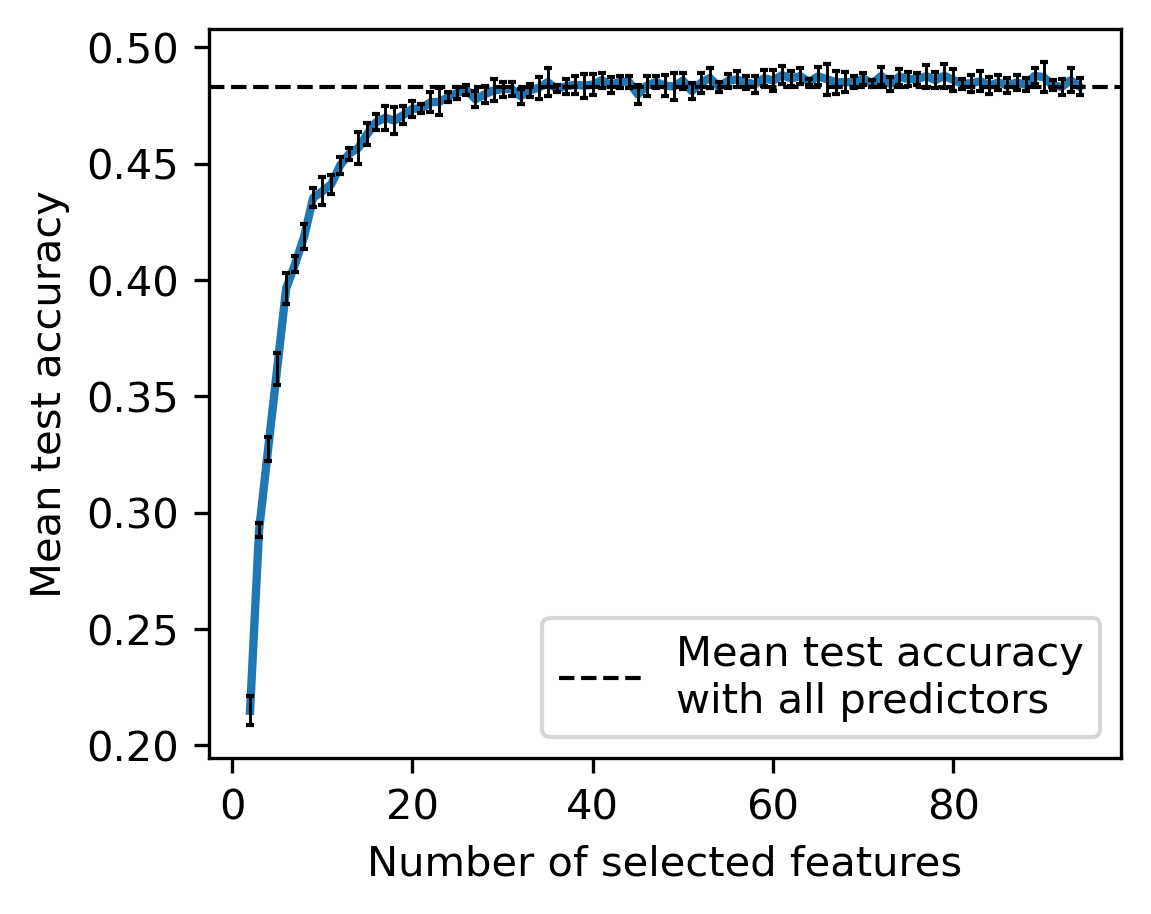

In [180]:
n_scores = len(rfe_accuracies_mean)

fig, ax = plt.subplots(figsize=(10/2.54, 8/2.54), dpi=300)

ax.set_xlabel("Number of selected features")
ax.set_ylabel("Mean test accuracy")

ax.errorbar(
    x=range(min_feats_to_select, n_scores + min_feats_to_select),
    y=list(reversed(rfe_accuracies_mean)),
    yerr=list(reversed(rfe_accuracies_std)),
    linewidth=2,
    ecolor='black',
    elinewidth=0.7,
    capsize=1,
    zorder=10,
)

ax.axhline(
    y=rfe_accuracies_mean[0],
    linewidth=1,
    linestyle='--',
    color='k',
    label="Mean test accuracy\nwith all predictors",
    zorder=20,
)

lines = ax.get_lines()
lines[0].set_zorder(-2)
ax.legend()

fig.tight_layout()
fig.savefig(
    '../results/plots/rfe_permutation_importance.png'
)

In [166]:
# Save data
result_dict = {}
result_dict['dropped_columns'] = dropped_columns
result_dict['included_columns'] = included_columns
result_dict['rfe_importances_mean'] = rfe_importances_mean
result_dict['rfe_importances_std'] = rfe_importances_std
result_dict['rfe_accuracies_mean'] = rfe_accuracies_mean
result_dict['rfe_accuracies_std'] = rfe_accuracies_std

with open('../results/var_selection_results.pkl', 'wb') as pkl_file:
    pickle.dump(obj=result_dict, file=pkl_file)

In [167]:
# Load data?
with open('../results/var_selection_results.pkl', 'rb') as pkl_file:
    test_dict = pickle.load(pkl_file)

test_dict

{'dropped_columns': ['B9_median_comp_Sent2',
  'SAVI_greenest_pixel_Sent2',
  'swe_10',
  'proxy_lakes',
  'aspect',
  'geology_norge',
  'geo_infiltr_evne',
  'bioclim_15',
  'NDVI_median_comp_Lands7',
  'swe_8',
  'tmax_8',
  'EVI_greenest_pixel_Lands7',
  'tmax_10',
  'GNDVI_median_comp_Lands7',
  'EVI_median_comp_Lands7',
  'geo_grunnvann',
  'proxy_allrivers',
  'bioclim_11',
  'proxy_allwater',
  'B1_median_comp_Sent2',
  'total_insolation',
  'geo_losmasse',
  'sca_8',
  'B1_median_comp_Lands7',
  'B5_median_comp_Lands7',
  'B7_median_comp_Sent2',
  'sca_7',
  'tmax_5',
  'tmax_9',
  'bioclim_18',
  'B8_median_comp_Sent2',
  'B6_median_comp_Lands7',
  'bioclim_5',
  'valley_depth',
  'B7_median_comp_Lands7',
  'geo_berggrunn',
  'vertical_distance_to_channel_network',
  'sca_9',
  'tmax_1',
  'bioclim_6',
  'tmin_9',
  'sca_2',
  'corine_lc_2012',
  'tmax_6',
  'B4_median_comp_Lands7',
  'B6_median_comp_Sent2',
  'bioclim_1',
  'slope',
  'tmax_2',
  'B2_median_comp_Lands7',
  '

In [5]:
# Permutation importance with the 25 most important variables
#vt_X_25_selected = vt_X[list(reversed(dropped_columns))[0:24] + ['NDVI_greenest_pixel_Sent2']]
selected_vars = [
    'B11_median_comp_Sent2', 'growing_season_length', 'ar50_veg',
    'B4_median_comp_Sent2', 'B3_median_comp_Lands7', 'ar50_treslag',
    'NDMI_greenest_pixel_Sent2', 'bioclim_17', 'NDVI_median_comp_Sent2',
    'GNDVI_greenest_pixel_Sent2', 'bioclim_10', 'terrain_ruggedness_index',
    'B8A_median_comp_Sent2', 'proxy_coast', 'NDVI_greenest_pixel_Lands7',
    'ar50_artype', 'SAVI_median_comp_Lands7', 'B12_median_comp_Sent2',
    'precip_5', 'GNDVI_median_comp_Sent2', 'dem100', 'bioclim_7',
    'NDMI_greenest_pixel_Lands7', 'visible_sky',
    'NDVI_greenest_pixel_Sent2'
]
vt_X_25_selected = vt_X[selected_vars]

permutation_results = []

# Calculate permutation importance for cv
for fold_idx, (train_indices, test_indices) in enumerate(split_indices):

    estimator = RandomForestClassifier(n_jobs=20, random_state=221)
            
    # Fit estimator
    estimator.fit(
        X=vt_X_25_selected.iloc[train_indices],
        y=vt_y.iloc[train_indices],
    )

    # Calculate permutation importance on held out data
    cur_perm_importance = permutation_importance(
        estimator=estimator,
        X=vt_X_25_selected.iloc[test_indices],
        y=vt_y.iloc[test_indices],
        scoring='accuracy',
        n_repeats=5,
        random_state=221,
        n_jobs=5,
    )

    permutation_results.append(cur_perm_importance)

    print(f"Finished fold {fold_idx+1} of {len(split_indices)}.")

Finished fold 1 of 5.
Finished fold 2 of 5.


/uio/kant/geo-geofag-u1/lassetk/.conda/envs/dmvtnor-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished fold 3 of 5.
Finished fold 4 of 5.
Finished fold 5 of 5.


In [6]:
# Calculate mean across folds

importances_mean = np.zeros(shape=(25,))
importances_std = np.zeros(shape=(25,))

for permutation_fold in permutation_results:
    importances_mean += permutation_fold['importances_mean']
    importances_std += permutation_fold['importances_std']
importances_mean /= len(permutation_results)
importances_std /= len(permutation_results)

In [116]:
vt_X_25_selected.columns

Index(['B11_median_comp_Sent2', 'growing_season_length', 'ar50_veg',
       'B4_median_comp_Sent2', 'B3_median_comp_Lands7', 'ar50_treslag',
       'NDMI_greenest_pixel_Sent2', 'bioclim_17', 'NDVI_median_comp_Sent2',
       'GNDVI_greenest_pixel_Sent2', 'bioclim_10', 'terrain_ruggedness_index',
       'B8A_median_comp_Sent2', 'proxy_coast', 'NDVI_greenest_pixel_Lands7',
       'ar50_artype', 'SAVI_median_comp_Lands7', 'B12_median_comp_Sent2',
       'precip_5', 'GNDVI_median_comp_Sent2', 'dem100', 'bioclim_7',
       'NDMI_greenest_pixel_Lands7', 'visible_sky',
       'NDVI_greenest_pixel_Sent2'],
      dtype='object')

In [7]:
importances_mean

array([0.0128084 , 0.0120326 , 0.02447154, 0.01518055, 0.01215888,
       0.02027701, 0.01086904, 0.00995792, 0.01143715, 0.00972348,
       0.00955199, 0.00851473, 0.01140111, 0.00797361, 0.01193332,
       0.01427864, 0.01097736, 0.0083524 , 0.00883029, 0.0105624 ,
       0.00820817, 0.00861389, 0.00967825, 0.00614254, 0.02128705])

In [8]:
print(importances_mean)
sorted_idx = np.argsort(importances_mean)
print(importances_mean[sorted_idx])

[0.0128084  0.0120326  0.02447154 0.01518055 0.01215888 0.02027701
 0.01086904 0.00995792 0.01143715 0.00972348 0.00955199 0.00851473
 0.01140111 0.00797361 0.01193332 0.01427864 0.01097736 0.0083524
 0.00883029 0.0105624  0.00820817 0.00861389 0.00967825 0.00614254
 0.02128705]
[0.00614254 0.00797361 0.00820817 0.0083524  0.00851473 0.00861389
 0.00883029 0.00955199 0.00967825 0.00972348 0.00995792 0.0105624
 0.01086904 0.01097736 0.01140111 0.01143715 0.01193332 0.0120326
 0.01215888 0.0128084  0.01427864 0.01518055 0.02027701 0.02128705
 0.02447154]


In [9]:
### Read variable dictionary
import json

with open("../data/dict/predictors.json", 'r', encoding="utf8") as file:
        var_dict = json.load(file)

In [148]:
var_dict

{'x': {'long_name': 'Easting',
  'dtype': 'continuous',
  'unit': 'm [UTM 32N WGS84]'},
 'y': {'long_name': 'Northing',
  'dtype': 'continuous',
  'unit': 'm [UTM 32N WGS84]'},
 'plot_id': {'long_name': 'Plot ID', 'dtype': 'categorical', 'unit': 'NA'},
 'B1_median_comp_sent2': {'long_name': 'Sent2 - B1 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B2_median_comp_sent2': {'long_name': 'Sent2 - B2 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B3_median_comp_sent2': {'long_name': 'Sent2 - B3 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B4_median_comp_sent2': {'long_name': 'Sent2 - B4 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B5_median_comp_sent2': {'long_name': 'Sent2 - B5 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B6_median_comp_sent2': {'long_name': 'Sent2 - B6 (MED)',
  'dtype': 'continuous',
  'unit': 'Surface reflectance'},
 'B7_median_comp_sent2': {'long_name': 

In [10]:
# Esri color ramps - Falling Leaves
category_colors: dict = {
    "Satellite": "#3e756dff",
    "Baseline land cover": "#d9d78cff",
    "Geospatial": "#b86b53ff",
    "Climate": "#5c98caff",
    "Geology": "#9c5596ff",
}

/tmp/ipykernel_1400925/2731675814.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


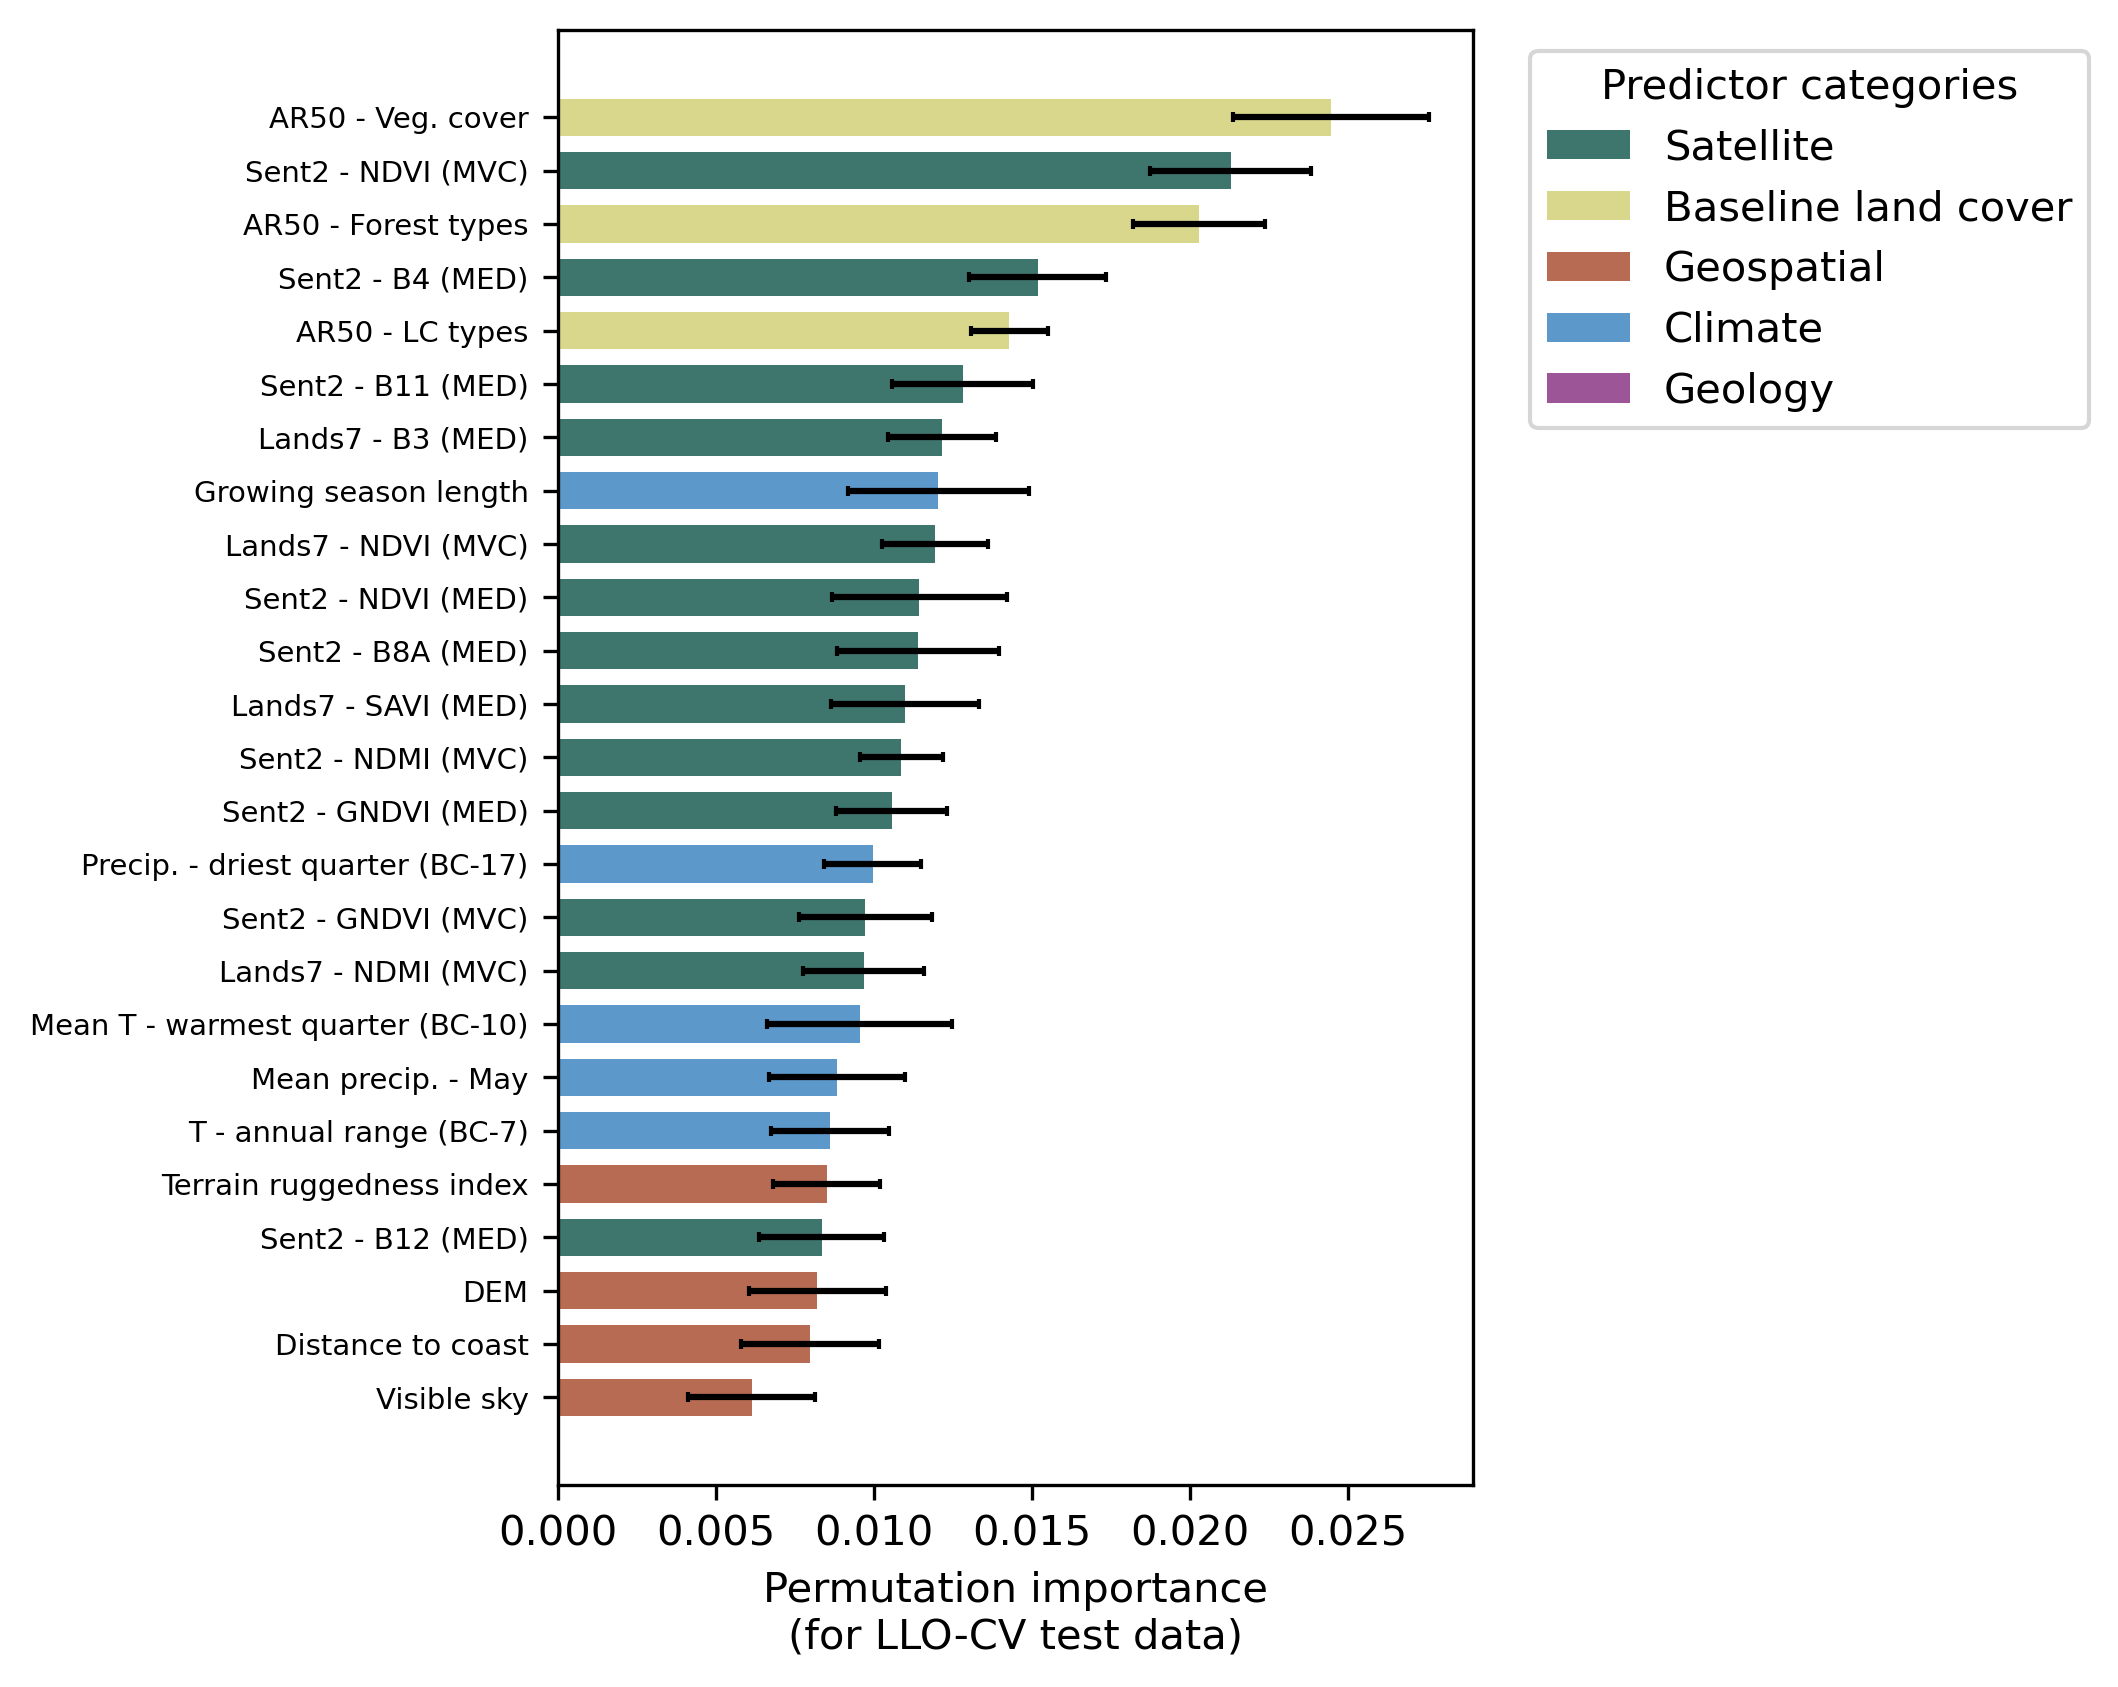

In [18]:
fig, ax = plt.subplots(figsize=(10/2.54, 16/2.54), dpi=300)

sorted_idx = np.argsort(importances_mean)

colors = [
    category_colors[var_dict[x]['category']] for x in vt_X_25_selected.columns[sorted_idx]
]

ax.barh(
    y=np.arange(len(vt_X_25_selected.columns)),
    width=importances_mean[sorted_idx],
    height=0.7,
    color=colors,#'red',
    xerr=importances_std[sorted_idx],
    capsize=1.1,
    #left=rf_cur_height,
)

# Dummies for legend
included_categories = [var_dict[x]['category'] for x in vt_X_25_selected.columns]

for cat_name, cat_color in category_colors.items():

    if cat_name in included_categories:

        ax.barh(
            y=np.arange(len(vt_X_25_selected.columns)),
            width=np.zeros(shape=(len(vt_X_25_selected.columns),)),
            color=cat_color,
            label=cat_name,
        )

y_labels = [
    var_dict[x]['long_name'] for x in vt_X_25_selected.columns[sorted_idx]
]

ax.set_yticks(range(25))
ax.set_yticklabels(y_labels, fontsize=7)
ax.legend(
    title="Predictor categories",
    bbox_to_anchor=(1.04, 1), loc="upper left"
)

ax.set_xlabel("Permutation importance\n(for LLO-CV test data)")

fig.tight_layout()
#fig.savefig('../results/plots/var_importance_25_selected.png')

In [9]:
''' OUTDATED

rf = RandomForestClassifier(n_jobs=10, random_state=221)
min_feats_to_select = 1

selector = RFECV(
    estimator=rf,
    cv=split_indices,
    verbose=2,
    scoring='accuracy',
    n_jobs=10,
    step=1,  # How many features to discard per iteration
    min_features_to_select=min_feats_to_select,  # Min number of features
)

selector = selector.fit(
    X=vt_X,
    y=vt_y
)
'''

Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 89 features.
Fitting estimator with 89 fe

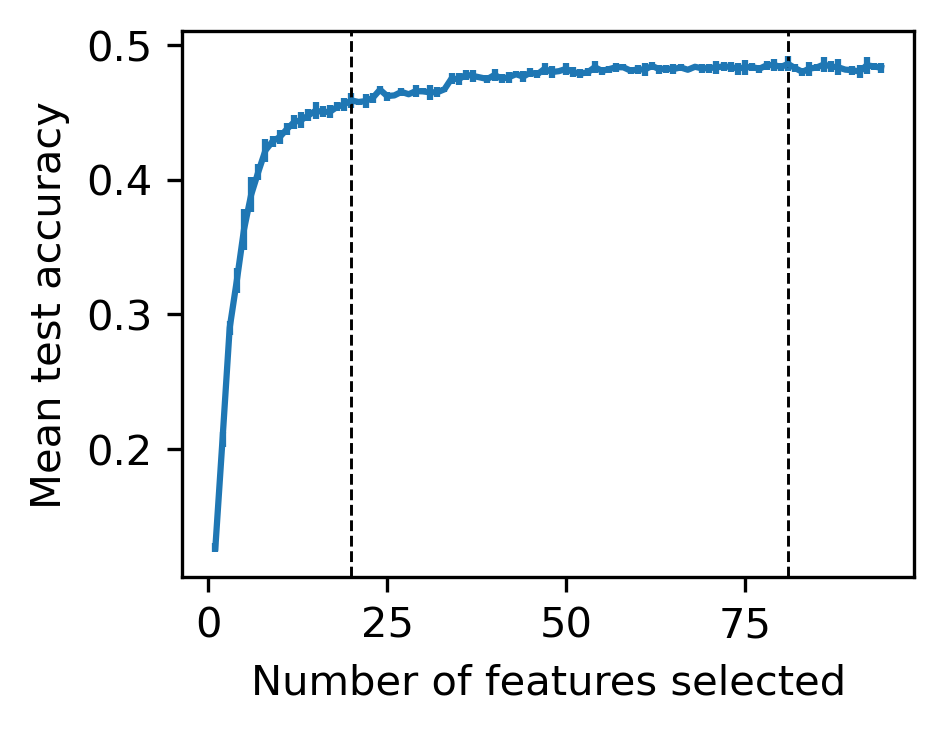

In [23]:
n_scores = len(selector.cv_results_["mean_test_score"])

fig, ax = plt.subplots(figsize=(8/2.54, 6/2.54), dpi=300)

ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test accuracy")
ax.errorbar(
    range(min_feats_to_select, n_scores + min_feats_to_select),
    selector.cv_results_["mean_test_score"],
    yerr=selector.cv_results_["std_test_score"],
)
ax.axvline(
    x=selector.n_features_,
    linewidth=0.7,
    linestyle='--',
    color='k',
)
ax.axvline(
    x=20,
    linewidth=0.7,
    linestyle='--',
    color='k',
)
#ax.set_title("Recursive Feature Elimination \nwith correlated features")

In [20]:
selector.cv_results_

{'mean_test_score': array([0.12704626, 0.20732413, 0.29008259, 0.32525986, 0.36309892,
        0.38880634, 0.40580854, 0.42177388, 0.42853888, 0.43169582,
        0.43755896, 0.4427452 , 0.44432384, 0.44770626, 0.45122413,
        0.45032223, 0.4503672 , 0.45402031, 0.45595962, 0.45884619,
        0.45767373, 0.45830518, 0.46078554, 0.46678364, 0.46204841,
        0.46254466, 0.46516045, 0.46340131, 0.4657466 , 0.46552092,
        0.46479938, 0.46488948, 0.46705442, 0.47512719, 0.47454124,
        0.4779234 , 0.4769762 , 0.47584902, 0.47472133, 0.4776977 ,
        0.47503713, 0.47602916, 0.47828432, 0.47643508, 0.47945669,
        0.47828445, 0.48229789, 0.47986263, 0.48053935, 0.48225297,
        0.47972757, 0.47882531, 0.47959234, 0.48351616, 0.48076483,
        0.48202771, 0.48351612, 0.48338082, 0.48094553, 0.48180239,
        0.48180224, 0.484373  , 0.48207287, 0.48234328, 0.48211756,
        0.48329035, 0.4815768 , 0.48378675, 0.48256881, 0.48283946,
        0.48338061, 0.4840570

In [22]:
vars(selector)

{'estimator': RandomForestClassifier(n_jobs=10, random_state=221),
 'step': 1,
 'importance_getter': 'auto',
 'cv': [(array([    0,     1,     3, ..., 22168, 22169, 22170]),
   array([    2,     7,     9, ..., 22157, 22171, 22172])),
  (array([    0,     1,     2, ..., 22170, 22171, 22172]),
   array([   14,    58,    67, ..., 22158, 22166, 22167])),
  (array([    0,     1,     2, ..., 22168, 22171, 22172]),
   array([   11,    12,    23, ..., 22164, 22169, 22170])),
  (array([    0,     2,     4, ..., 22170, 22171, 22172]),
   array([    1,     3,     6, ..., 22163, 22165, 22168])),
  (array([    1,     2,     3, ..., 22170, 22171, 22172]),
   array([    0,     4,     5, ..., 22146, 22159, 22162]))],
 'scoring': 'accuracy',
 'verbose': 2,
 'n_jobs': 10,
 'min_features_to_select': 1,
 'feature_names_in_': array(['B11_median_comp_Sent2', 'B12_median_comp_Sent2',
        'B1_median_comp_Sent2', 'B2_median_comp_Sent2',
        'B3_median_comp_Sent2', 'B4_median_comp_Sent2',
        'B5_me

In [13]:
print(f"Optimal number of features: {selector.n_features_}")
selector.ranking_

Optimal number of features: 81


array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  5, 12,  9,  8, 10,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,
        6,  1,  1,  7, 11, 13,  4,  1,  1,  1, 14,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1])